In [1]:
#used packages
import torch
import json
################################1. preparing the utilities functions to process our data
#Here we define the utilities function to process our data, i.e. nodes and edges and thier features (attributes)
#For representing this data in the PyG data format, we first define a method load_node_csv() that reads 
#in a *.csv file and returns a node-level feature representation x of shape [num_nodes, num_features]:

###############################1.1 function to Load node-realted data
#load_node_csv() reads the *.csv file from path, and creates a dictionary mapping that maps its index column 
#to a consecutive value e.g., the representation of a resource in the first row should be accessible via x[0].

def load_node_csv(path, mapping, encoders=None, **kwargs):
    x_mapping = {}
    df = pd.read_csv(path, index_col="resourceid", **kwargs)
    
    # Update x_mapping with unique node IDs, excluding "None"
    for index in df.index.unique():
        if index != "None":
            x_mapping[index] = len(x_mapping)
    
    # Update mapping dictionary with unique node IDs, excluding "None"
    unique_ids = df.index.unique()
    for node_id in unique_ids:
        if node_id != "None" and node_id not in mapping:
            mapping[node_id] = len(mapping)
    
    # Create indices tensor
    indices = torch.tensor([mapping[node_id] for node_id in unique_ids if node_id != "None"])
    #print("indices", indices)
    
    x = None
    if encoders is not None:
        xs = [encoder(df.loc[df.index != "None", col]) for col, encoder in encoders.items()]
        x = torch.stack(xs, dim=1)
        # Uncomment the following line if you want to concatenate indices with encoded features
        # x = torch.cat((indices.unsqueeze(1), torch.stack(xs, dim=1)), dim=1)

    return x, x_mapping

################################################2.2 function to Load edge-related data
#loading of edges 
#load_edge_csv() returns the final edge_index representation of shape [2, number_of_each_edges_types] 
#from *.csv

def load_edge_csv(path, src_mapping, dst_mapping, encoders=None, **kwargs):
    # Read the CSV file
    df = pd.read_csv(path, **kwargs)
    # Assuming the first column is the source index column and the second is the destination index column
    src_index_col = df.columns[0]
    dst_index_col = df.columns[1]
    src = []
    dst = []
    valid_rows = []

    # Map source and destination indices using provided mappings, skipping "None"
    for i, (src_index, dst_index) in enumerate(zip(df[src_index_col], df[dst_index_col])):
        if src_index != "None" and dst_index != "None":
            src.append(src_mapping[src_index])
            dst.append(dst_mapping[dst_index])
            valid_rows.append(i)
    
    # Create edge_index tensor
    edge_index = torch.tensor([src, dst], dtype=torch.long)
    edge_attr = None
    if encoders is not None:
        # Apply encoders only to valid rows
        edge_attrs = [encoder(df.loc[valid_rows, col]) for col, encoder in encoders.items()]
        edge_attr = torch.cat(edge_attrs, dim=-1)

    return edge_index, edge_attr

#src_index_col and dst_index_col define the index columns of source and destination nodes, 
#encoders are used to return additional edge-level feature information using one of NLP models


################################################1.3 function to define an encoder that applies on of NLP model to encode node/edgae related features 
from sentence_transformers import SentenceTransformer
class SequenceEncoder(object):
    def __init__(self, model_name='all-MiniLM-L6-v2', device=None):
        self.device = device
        self.model = SentenceTransformer(model_name, device=device)

    @torch.no_grad()
    def __call__(self, df):
        x = self.model.encode(df.values, show_progress_bar=True,
                              convert_to_tensor=True, device=self.device)
        return x.cpu()


class ProviderEncoder(object):
    def __call__(self, df):
        tensor_val=torch.tensor(df.values,dtype=torch.float)

        return tensor_val.cpu()
class TypeEncoder(object):
    def __call__(self, df):
        tensor_val=torch.tensor(df.values,dtype=torch.float)

        return tensor_val.cpu()

class LocationEncoder(object):
    def __init__(self, dtype=None):
        self.dtype = dtype

    def __call__(self, df):
        tensor_val=torch.tensor(df.values,dtype=torch.float)

        return tensor_val.cpu()

def load_labels(path):
##load the labels of services
      with open(path) as f:
        labels = json.load(f)
        print (labels)
      return labels 
########################2) Load the data from the given dataset using the defined utilities functions

#steps:
#A) load graphs from CSV files 
from torch_geometric.data import download_url, extract_zip
import pandas as pd
from torch_geometric.data import HeteroData
from torch_geometric.loader import DataLoader
import os
def load_data(dir_path,labels,service_label,mapping):

  providers = os.listdir(dir_path)
  data_set = []
  graph_i=0
  for provider in providers:
          services=os.listdir(dir_path+'/'+provider)
          for service in services:
                     #graph_mapping.update({provider+'-'+service+'-'+instance: graph_i})
                     service_files=os.listdir(dir_path+'/'+provider+'/'+service)
                     path=dir_path+'/'+provider+'/'+service+'/'
                    # print(service_files)
                     resource_path = path+'nodes.csv'
                     #1) load nodes
                     resource_x,mapping_x = load_node_csv(
                     resource_path, mapping, encoders={
                      'type': TypeEncoder(), 
                      'provider':ProviderEncoder()
                       
                       })
                     #print(resource_path)
                      #initialize our HeteroData object and pass the node type into it
                     data= HeteroData()
                     data['resource'].x = resource_x
                                #2 load edges
                     for file in service_files:
                            if ('.csv' in file) and (file!='nodes.csv'):
                                    edge_path=path+file
                                    edge_index_relationship, edge_label_relationship= load_edge_csv(
                                    edge_path,
                                    src_mapping=mapping_x,
                                    dst_mapping=mapping_x,
                                    encoders=None,)  
                                    relation_name=file.replace('.csv', '')
                                    if edge_index_relationship.size(1)!=0:
                                        data['resource', relation_name, 'resource'].edge_index =  edge_index_relationship
                     data.y=torch.tensor(int(labels[provider+'_'+service_label]), dtype=torch.long) 
                     data_set.append(data)

                     graph_i+=1


  print(mapping)
  return data_set

In [2]:
#Generate training data
import random
import os
##Put here the path of dataset
current_folder = 'C:/env/'
mapping={}
label_path = os.path.join(current_folder, 'Heterogeneous_Graph_Learning/dataset/service_labels.json')
labels=load_labels(label_path)
#dir_path=r'Heterogeneous_Graph_Learning/dataset/services/'
dir_path=os.path.join(current_folder,'Heterogeneous_Graph_Learning/dataset/services/')

#will generate dataset for each service so that we can organize the finale dataset into training and testing in a fair way
L2B_graphs_path =dir_path+'L2bridging'
L2C_graphs_path =dir_path+'L2Connectivity'
L2E_graphs_path =dir_path+'L2endpoint'
L3R_graphs_path =dir_path+'L3routing'
NIC_graphs_path =dir_path+'NIC'
#Peering_graphs_path =dir_path+'peering_services' (Removed for now)

L2B_services=load_data(L2B_graphs_path,labels,'L2bridging',mapping)#
L2C_services=load_data(L2C_graphs_path,labels,'L2Connectivity',mapping)#
L2E_services=load_data(L2E_graphs_path,labels,'L2endpoint',mapping)#
L3R_services=load_data(L3R_graphs_path,labels,'L3routing',mapping)#
NIC_services=load_data(NIC_graphs_path,labels,'NIC',mapping)#
#Peering_services=load_data(Peering_graphs_path,labels)# (Removed for now)








{'aws_NIC': '0', 'azure_NIC': '1', 'aws_L2Connectivity': '2', 'azure_L2Connectivity': '3', 'aws_L2endpoint': '4', 'azure_L2endpoint': '5', 'aws_L2bridging': '6', 'azure_L2bridging': '7', 'aws_L3routing': '8', 'azure_L3routing': '9', 'aws_peering': '10', 'azure_peering': '11'}
{'L2_Bridging': 0, 'Node_L2Domain': 1, 'Node_L3Domain': 2, 'Subnet': 3}
{'L2_Bridging': 0, 'Node_L2Domain': 1, 'Node_L3Domain': 2, 'Subnet': 3, 'L2Address': 4, 'L2_Endpoint': 5, 'VM': 6}
{'L2_Bridging': 0, 'Node_L2Domain': 1, 'Node_L3Domain': 2, 'Subnet': 3, 'L2Address': 4, 'L2_Endpoint': 5, 'VM': 6}
{'L2_Bridging': 0, 'Node_L2Domain': 1, 'Node_L3Domain': 2, 'Subnet': 3, 'L2Address': 4, 'L2_Endpoint': 5, 'VM': 6, 'L3Address3': 7, 'L3EndPointServiceDestination': 8, 'L3EndPointServiceSource': 9, 'L3RouterService': 10, 'Subnet1_To_Subnet2': 11, 'Subnet2_To_Subnet1': 12, 'Subnet3': 13}
{'L2_Bridging': 0, 'Node_L2Domain': 1, 'Node_L3Domain': 2, 'Subnet': 3, 'L2Address': 4, 'L2_Endpoint': 5, 'VM': 6, 'L3Address3': 7, 'L

In [3]:
#shuffling datac
random.shuffle(L2B_services)
random.shuffle(L2C_services)
random.shuffle(L2E_services)
random.shuffle(L3R_services)
random.shuffle(NIC_services)
#random.shuffle(Peering_services)(Removed for now)
print(len(L2B_services))
print(len(L2C_services))
print(len(L2E_services))
print(len(L3R_services))
print(len(NIC_services))
#print(len(Peering_services))(Removed for now)

#training
training_data_set=L2B_services[:250]+L2C_services[:250]+L2E_services[:250]+L3R_services[:60]+NIC_services[:250]
#+Peering_services[:300]
print(len(training_data_set))
random.shuffle(training_data_set)
#testing 

testing_data_set=L2B_services[250:]+L2C_services[250:]+L2E_services[250:]+L3R_services[60:]+NIC_services[250:]
#Peering_services[300:]
print(len(testing_data_set))
random.shuffle(testing_data_set)
#Printing some training and testing data
print (training_data_set[0])
print(testing_data_set[2])

320
320
320
81
320
1060
301
HeteroData(
  y=2,
  resource={ x=[7, 2] },
  (resource, Belong_To, resource)={ edge_index=[2, 1] },
  (resource, exposes_resource_L2Address, resource)={ edge_index=[2, 1] },
  (resource, exposes_resource_Subnet, resource)={ edge_index=[2, 1] },
  (resource, Hosted_On_L2Domain, resource)={ edge_index=[2, 1] },
  (resource, Hosted_On_Node, resource)={ edge_index=[2, 1] },
  (resource, Is_Owned_By, resource)={ edge_index=[2, 1] },
  (resource, Require_Resource_Subnet, resource)={ edge_index=[2, 1] }
)
HeteroData(
  y=3,
  resource={ x=[7, 2] },
  (resource, Belong_To, resource)={ edge_index=[2, 1] },
  (resource, exposes_resource_L2Address, resource)={ edge_index=[2, 1] },
  (resource, exposes_resource_Subnet, resource)={ edge_index=[2, 1] },
  (resource, Hosted_On_L2Domain, resource)={ edge_index=[2, 1] },
  (resource, Hosted_On_Node, resource)={ edge_index=[2, 1] },
  (resource, Is_Owned_By, resource)={ edge_index=[2, 1] },
  (resource, Require_Resource_Subn

In this step, we want to train a model that takes the nodes features and predicts the type of edge among an edge type list.

In [4]:
def data_reformulation(loader):
    index = {}
    mapping = []
    labels = []

    for graph in loader:
        for typ in graph.edge_types:
            if typ not in index:
                index[typ] = len(index)
            edge_index = graph[typ]['edge_index']
            src, dst = edge_index[0], edge_index[1]
            for s, d in zip(src, dst):
                # Flatten the features of the source and destination nodes into a single list
                source_features = graph['resource'].x[s].tolist()
                destination_features = graph['resource'].x[d].tolist()
                combined_features = source_features + destination_features
                mapping.append(combined_features)
                labels.append(index[typ])
            
    return mapping, labels, index

In [5]:
datas=[]
datas.extend(training_data_set)
datas.extend(testing_data_set)
size=int(0.7*len(datas))
train=datas[:size]
test=datas[size:]

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
def train_model(training_data_set):
    mapping_training, labels_training, index_training = data_reformulation(training_data_set)
    classifier = RandomForestClassifier(n_estimators=100)
    classifier.fit(mapping_training, labels_training)
    return classifier, index_training

def evaluate_model(classifier, testing_data_set):
    mapping_testing, labels_testing, _ = data_reformulation(testing_data_set)
    y_pred = classifier.predict(mapping_testing)
    accuracy = accuracy_score(labels_testing, y_pred)
    return accuracy
for epoch in range(1, 5):
    classifier, index_training=train_model(train)
    val_acc_train = evaluate_model(classifier,train)
    print(f'Val train: {val_acc_train}')
    val_acc = evaluate_model(classifier,test)
    print(f'Val: {val_acc}')

Val train: 1.0
Val: 1.0
Val train: 1.0
Val: 1.0
Val train: 1.0
Val: 1.0
Val train: 1.0
Val: 1.0


In [6]:
def predict_new_edges(classifier, mapping_new, index_training):
    y_pred = classifier.predict(mapping_new)
    
    # Convert predictions back to edge types using the index
    reverse_index = {v: k for k, v in index_training.items()}
    predicted_edge_types = [reverse_index[pred] for pred in y_pred]
    return predicted_edge_types


In this step, we are going to calculate the expression of the graphon.

In [7]:
import torch
from torch_geometric.data import HeteroData
import numpy as np

def create_adjacency_matrix(hetero_data):
    num_nodes = hetero_data['resource']['x'].shape[0]
    adj_matrix = np.zeros((num_nodes, num_nodes), dtype=int)
    for edge_type in hetero_data.edge_types:
        edge_index = hetero_data[edge_type]['edge_index']
        src, dst = edge_index[0], edge_index[1]
        for s, d in zip(src.tolist(), dst.tolist()):
            adj_matrix[s, d] = 1
    return adj_matrix
#return the adjancy matrix

In [8]:
import numpy as np
# computes the distribuation mu_m

def compute_mu_m(A_m):
    # Create the indicator vector 1_Nm
    iden_Nm = np.ones((A_m.shape[0],1))
    # Compute A_m * 1_Nm
    A_m_1_Nm = A_m @ iden_Nm
    # Compute the norm ||A_m * 1_Nm||_1
    norm_A_m_1_Nm = np.linalg.norm(A_m_1_Nm, 1)
    # Compute the final result
    mu_m = (1 / norm_A_m_1_Nm) * A_m_1_Nm

    return mu_m


In [9]:
from scipy.interpolate import interp1d
import numpy as np

#Computes the distribution mu_W
def compute_mu_W(mu_list, K):
    M = len(mu_list)
    interpolated_values = []
    
    for mu_m in mu_list:
        # Flatten and sort mu_m in descending order
        sorted_mu_m = np.sort(np.ravel(mu_m))[::-1]
        
        # Create the interpolation function
        x = np.linspace(0, len(sorted_mu_m) - 1, num=len(sorted_mu_m))
        interpolation_function = interp1d(x, sorted_mu_m, kind='linear', fill_value="extrapolate")
        
        # Interpolate K values
        xp = np.linspace(0, len(sorted_mu_m) - 1, num=K)
        interpolated_mu_m = interpolation_function(xp)
        
        # Collect interpolated values
        interpolated_values.append(interpolated_mu_m)
    
    # Average of interpolated values
    mu_W = np.mean(interpolated_values, axis=0)
    return mu_W.reshape(-1, 1)



In [10]:
def determine_N_max(loader):
    N_max=0
    for graph in loader:
        if len(graph['resource'].x)>N_max:
            N_max=len(graph['resource'].x)
    return N_max


In [11]:
import math
#Hyperparaters:
beta = 500  # Example value for beta
L = 5  # Number of outer iterations
S = 5  # Number of inner Sinkhorn iterations
epsilon = 1e-8 


In [12]:
def initialize_W_uniform(shape):
    return np.random.uniform(0, 1, shape)


In [13]:
import numpy as np
import networkx as nx
from scipy.optimize import linprog
from scipy.interpolate import interp1d

def learning_graphons_via_gwb(A_M, beta, L, S, N_max):
    # Step 1: Initialization
    K=math.floor(N_max / np.log(N_max)) 
    M = len(A_M)
    W = initialize_W_uniform((K, K))
    MU_m=[compute_mu_m(A_m) for A_m in A_M ]
    mu_w=compute_mu_W(MU_m,K)
    for l in range(L):
        T_list = []
        for m in range(M):
            a=MU_m[m]
            T_m = MU_m[m] @mu_w.T
            T = T_m.copy()
            Am = A_M[m]
            Dm =(Am*Am)@MU_m[m]@np.ones((1,K))+np.ones((len(Am),1))@mu_w.T@(W*W)
            # Initialize Dm here, needs to be defined based on your data
            for s in range(S):
                C = np.exp(-1 / beta * (Dm - 2 * Am @ T@(W.T)) * T)
                b = mu_w / ((C.T) @ a+epsilon)
                a = MU_m[m] / (C @ b+epsilon)
                diag_a=np.diag(np.ravel(a))
               
                diag_b=np.diag(np.ravel(b))
                T =diag_a  @ C @ diag_b
            T_list.append(T)
        W = sum(T_m.T @ Am @ T_m for T_m, Am in zip(T_list, A_M)) / M

    
    return W


In [14]:
import numpy as np

def create_intervals(K):
    interval_length = 1 / K
    intervals = [(i * interval_length, (i + 1) * interval_length) for i in range(K)]
    return intervals

def indicator(x, y, interval_x, interval_y):

    if interval_x[0] <= x < interval_x[1] and interval_y[0] <= y < interval_y[1]:
        return 1
    return 0

def W2_p(x, y, K, weights):
   
    intervals = create_intervals(K)
    W2_p_value = 0
    for k in range(K):
        for k_prime in range(K):
            interval_k = intervals[k]
            interval_k_prime = intervals[k_prime]
            indicator_value = indicator(x, y, interval_k, interval_k_prime)
            W2_p_value += weights[k, k_prime] * indicator_value
    return W2_p_value



In [15]:
#returns the classes within a loader
def classes(loader):
    y_values = [data.y.item() for data in loader]
    return(y_values)

In [17]:
def sort_matrix_by_degree(adj_matrix, features_matrix):
    degrees = np.sum(adj_matrix, axis=1)
    # Get sorted indices based on degree
    sorted_indices = np.argsort(degrees)
    
    # Sort adjacency matrix and features matrix based on sorted indices
    sorted_adj_matrix = adj_matrix[sorted_indices, :][:, sorted_indices]
    sorted_features_matrix = features_matrix[sorted_indices, :]
    
    return sorted_adj_matrix, sorted_features_matrix

In [18]:
import numpy as np

def average_pooling(features_matrix, N_max):
    K=math.floor(N_max / np.log(N_max)) 
    num_nodes, num_features = features_matrix.shape

    if K > num_nodes:
        raise ValueError("K cannot be greater than the number of nodes.")

    # Determine segment size
    segment_size = num_nodes // K

    # Add remaining nodes to the last segment if num_nodes is not perfectly divisible by K
    segment_size = max(segment_size, 1)

    # Add remaining nodes to the last segment if necessary
    segments = [features_matrix[i:i+segment_size] for i in range(0, num_nodes, segment_size)]
    
    if len(segments) < K:
        # If there are fewer segments than K, merge the last few segments
        segments[-2] = np.vstack((segments[-2], *segments[-1]))
        segments = segments[:-1]
    
    # Apply average pooling to each segment
    pooled_matrix = np.array([np.mean(segment, axis=0) for segment in segments])
    
    # If there are more segments than K, we need to truncate the number of segments
    if len(pooled_matrix) > K:
        pooled_matrix = pooled_matrix[:K]

    return pooled_matrix

In [19]:
def estimator(label,loader):
    labled_data = []
    new_data_set=labels_dataset(loader)
    for y in new_data_set:
        if y[0] == label:
            labled_data.append(y[1])
    
    global_sorted_adjancy = []
    global_sorted_features = []
    
    for graph in labled_data:
        features = np.stack([t.numpy() for t in graph['resource'].x])
        sorted_adjancy_matrix, sorted_feature_matrix = sort_matrix_by_degree(create_adjacency_matrix(graph), features)
        global_sorted_adjancy.append(sorted_adjancy_matrix)
        global_sorted_features.append(sorted_feature_matrix)
    N_max = determine_N_max(loader)
    weights = learning_graphons_via_gwb(global_sorted_adjancy, beta, L, S, N_max)
    all_pooled_features = np.vstack(features)
    # Compute the mean of the pooled features
    X_G = average_pooling(all_pooled_features, N_max)    
    return weights, X_G

In [20]:
import random
import numpy as np
import torch
from torch_geometric.data import HeteroData

def generate_synthetic_graph(W, X_graphon, classe, liste_of_edges):
    # Step 1: Sample K nodes independently from Unif[0,1]
    K = len(W)
    u = np.random.uniform(0, 1, K)

    # Initialize HeteroData
    graph = HeteroData()

    # Step 2: Generate the adjacency matrix A
    A = np.zeros((K, K), dtype=int)
    src = []
    dst = []
    
    for i in range(K):
        for j in range(K):
            if i != j:
                prob = W2_p(u[i], u[j], K, W)
                A[i, j] = np.random.binomial(1, prob)
                if A[i, j] == 1:
                    src.append(i)
                    dst.append(j)
                    
    combined_features = []
    if len(src) > 0 and len(dst) > 0:
        for s, d in zip(src, dst):
            combined_list = list(X_graphon[s, :]) + list(X_graphon[d, :])
            combined_features.append(combined_list)
        combined_features = np.array(combined_features)
        predicted_edge_types = predict_new_edges(classifier, combined_features, index_training)
    else:
        predicted_edge_types = []
    # Add a new feature if necessary
    if len(predicted_edge_types) < len(liste_of_edges):
        X_graphon = np.vstack([X_graphon, [12,X_graphon[0,1]]])

    X = torch.tensor(X_graphon, dtype=torch.float)
    graph['resource'].x = X

        # Add edges for the new node if necessary
    for edge in liste_of_edges:
        if edge not in predicted_edge_types:
            graph['resource', edge, 'resource'].edge_index = torch.tensor([[K], [K]], dtype=torch.long)

    # Create edge types tensor
    for lab in predicted_edge_types:
        occurrence = [i for i, x in enumerate(predicted_edge_types) if x == lab]
        if occurrence:
            index = [[src[i] for i in occurrence], [dst[i] for i in occurrence]]
            graph[ lab].edge_index = torch.tensor(index, dtype=torch.long)
    
    graph.y = torch.tensor(classe,dtype=torch.long)  # Assign the label to the graph

    return graph


In [21]:
liste_of_edges=  ['Belong_To', 'exposes_resource_L2Address',  'exposes_resource_L3Address', 'exposes_resource_L3SimpleRoute', 'exposes_resource_Subnet', 'Hosted_On_L2Domain', 'Hosted_On_L3Domain', 'Hosted_On_Node', 'Is_Owned_By', 'requires_service','Require_Resource_Subnet']


In [22]:
import random
def class_densities(loader):
    # Assuming labels_dataset and classes are predefined functions
    labels=classes(loader) 
    uniq_classes = len(set(labels))
    density = np.zeros(uniq_classes)
 
    for label in (labels):
        density[label] += 1
    density /= len(labels)  # Normalize by the total number of samples
    return density

def gmixup(loader,alpha_aug,alpha):
    I=[]
    labbels=classes(loader)
    density=class_densities(loader)
    for i in range(len(density)):
        density[i]=1/density[i] 
        density[i]+=+ 10**(-5)
        
    density/= (np.sum(density))
    print(density)

    # Sample synthetic graphs
    num_synthetic = int(alpha_aug * len(loader))
    for _ in range(num_synthetic):
        lambda_mix = np.random.beta(alpha, alpha)
        label1=np.random.choice(len(density), p=density)
        label2=np.random.choice(len(density), p=density)
        if lambda_mix<0.5:
            label=label2
            label2=label1
            label1=label            
        W_G,X_G=estimator(label1,loader)
        W_H,X_H=estimator(label2,loader)
        W_I = lambda_mix * W_G + (1 - lambda_mix) * W_H
        X_I = lambda_mix * X_G + (1 - lambda_mix) * X_H
        label_I=int(lambda_mix * label1 + (1 - lambda_mix) * label2)
        synthetic_graph = generate_synthetic_graph(W_I, X_I,label_I,liste_of_edges)
        if synthetic_graph != 0: 
            I.append(synthetic_graph)

    return I


In [ ]:
augmented_training_data=gmixup(training_data_set,1,0.5)
augmented_testing_data=gmixup(testing_data_set,1,0.5)

[0.05846178 0.05662047 0.0548916  0.06042688 0.05617812 0.05894098
 0.05574263 0.05942809 0.35953961 0.17976984]


In [27]:
graphs=augmented_training_data+augmented_testing_data


592
189


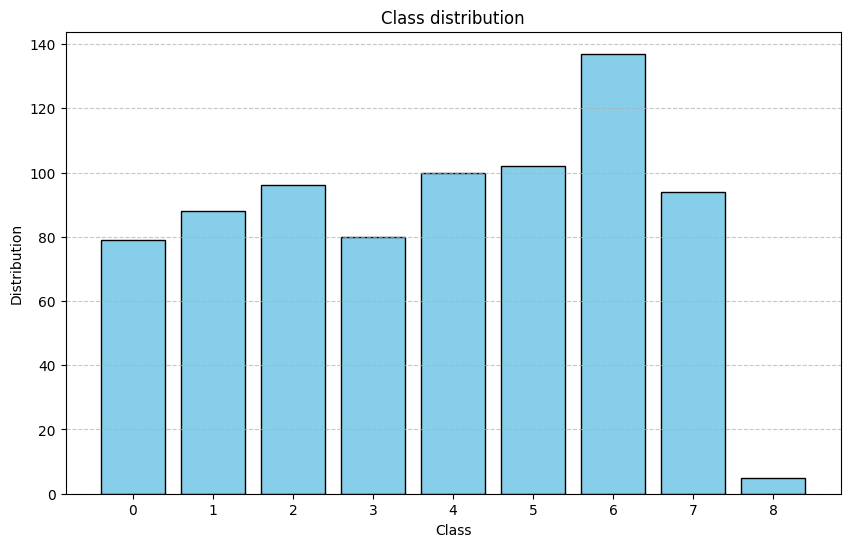

In [28]:
from collections import Counter
import matplotlib.pyplot as plt
y_values = [data.y.item() for data in graphs] 
occurrence_count = Counter(y_values)
labels, counts = zip(*occurrence_count.items())
plt.figure(figsize=(10, 6))
plt.bar(labels, counts, color='skyblue', edgecolor='black')
plt.title("Class distribution")
plt.xlabel('Class')
plt.ylabel("Distribution")
plt.xticks(labels)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [29]:
import torch
import os

# Define the file path
file_path = 'C:\\env\\Heterogeneous_Graph_Learning\\GNN-Model\\AugmentedGNN.pt'

# Check if the file exists
if os.path.exists(file_path):
    # Load existing data
    existing_data = torch.load(file_path)
    
    # Append new data to the existing data
    if isinstance(existing_data, list):
        existing_data.append(graphs)
    else:
        # Assuming existing_data is not a list, convert to list and append
        existing_data = [existing_data, graphs]
    
    # Save the updated data back to the file
    torch.save(existing_data, file_path)
else:
    # If the file does not exist, create a new file and save the data
    torch.save(graphs, file_path)
